# Portfolio Simulation Example

This notebook demonstrates how to use the Simulation class to create and analyze portfolio simulations with different strategies and constraints.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy

# Import the necessary classes
# Import the MarketModel class
import sys
sys.path.append('..')  # Add parent directory to path
from src.models.market_model import MarketModel
from src.simulations.simulation import Simulation

## Load and Prepare Data

Load historical price data for CAC40 stocks and ESG data.

In [2]:
# Create dictionary to store dataFrames for the 40 CAC40 companies
data_10y_dic = {}

# Get list of files containing 'Data' in the "Data/CAC40 daily 10y"
directory = "../Data/CAC40 daily 10y"
files = [f for f in os.listdir(directory) if 'Data' in f]

# Process each file
for file in files:
    # Get company name (first word before '_')
    company = file.split('_')[0]
    
    # Read the file with tab separator
    df = pd.read_csv(os.path.join(directory, file), sep='\t')
    
    # Convert first column to datetime and set as index
    df.index = pd.to_datetime(df['date'], format='%d/%m/%Y %H:%M')
    df = df.drop('date', axis=1)  # Remove the original date column
    df = df.dropna(axis=1, how='all') # Drop columns with all NaN values
    
    # Store in dictionary
    data_10y_dic[company] = df

# Create a DataFrame with all the closing prices
dfs = [df['clot'] for df in data_10y_dic.values()]
histo_CAC40 = pd.concat(dfs, axis=1, keys=data_10y_dic.keys())
histo_CAC40 = histo_CAC40.sort_index()

# Drop rows with NaN values
data = histo_CAC40.dropna()
print(f"Shape after dropping NaN rows: {data.shape}")

# Load ESG data
data_esg = pd.read_csv('../Data/InfoCAC40.csv', sep=';').set_index('Company').iloc[1:, :].T
# Convert string values to float
data_esg = data_esg.apply(lambda x: x.str.replace(',', '.').astype(float), axis=1)

# Display ESG data
data_esg.head()

Shape after dropping NaN rows: (1733, 40)


Company        Sustainability risk  Exposure risk  Score management  \
ACCORHOTELS                   16.1           43.6              69.2   
AIRBUS                        24.1           63.7              69.2   
AIRLIQUIDE                    13.2           36.1              69.9   
ARCELORMITTAL                 35.4           64.0              49.4   
AXA                           14.3           48.6              74.7   

Company        Carbon risk  Carbon intensity (Tons of CO2)  
ACCORHOTELS            8.4                          650.16  
AIRBUS                15.0                            9.80  
AIRLIQUIDE            19.3                         1235.98  
ARCELORMITTAL         21.8                         1706.33  
AXA                    3.0                            0.69

## Create and Calibrate a Market Model

Create a Black-Scholes market model and calibrate it using historical data.

In [3]:
# Create a MarketModel object
market_model_BS = MarketModel(model_name="BS")

# Calibrate the model
market_model_BS.fit(data)

# Display model parameters
print("Model parameters:")
print(f"Number of stocks: {len(market_model_BS.parameters['Stocks'])}")
print(f"Average annual return: {market_model_BS.parameters['Returns'].mean():.4f}")
print(f"Average annual volatility: {market_model_BS.parameters['Volatilities'].mean():.4f}")

Model parameters:
Number of stocks: 40
Average annual return: 0.0438
Average annual volatility: 0.3052


## Create Simulations with Different Strategies

Compare Buy and Hold vs. Rebalancing strategies.

In [4]:
# Number of scenarios
nb_scenarios = 50

# Equal weight allocation
nb_stocks = len(market_model_BS.parameters['Stocks'])
allocation_ew = np.ones(nb_stocks) / nb_stocks

# Import the weights data of CAC40
cac40_weights_df = pd.read_csv('../Data/InfoCAC40.csv', sep=';').set_index('Company')
# Convert string values to float
cac40_weights = cac40_weights_df.iloc[0, :].str.replace(',', '.').astype(float).values

# Use CAC40 weights for allocation
allocation = cac40_weights

# Create Buy and Hold simulation
parameters_buy_hold = {
    "Begin date": '2025-03-10',
    "End date": '2026-03-10',
    "Allocation": allocation,
}
simulation_buy_hold = Simulation(nb_scenarios=nb_scenarios, model=market_model_BS, strategy="Buy and hold", parameters=parameters_buy_hold)
simulation_buy_hold.generate_scenarios()
simulation_buy_hold.generate_evolutions()

# Create Rebalancing simulation (20 days)
parameters_rebal_20 = {
    "Begin date": '2025-03-10',
    "End date": '2026-03-10',
    "Allocation": allocation,
    "Rebalancing period": 20
}
simulation_rebal_20 = Simulation(nb_scenarios=nb_scenarios, model=market_model_BS, strategy="Rebalancing", parameters=parameters_rebal_20)
simulation_rebal_20.set_scenarios(simulation_buy_hold.scenarios)
simulation_rebal_20.generate_evolutions()

# Create Rebalancing simulation (5 days)
parameters_rebal_5 = {
    "Begin date": '2025-03-10',
    "End date": '2026-03-10',
    "Allocation": allocation,
    "Rebalancing period": 5
}
simulation_rebal_5 = Simulation(nb_scenarios=nb_scenarios, model=market_model_BS, strategy="Rebalancing", parameters=parameters_rebal_5)
simulation_rebal_5.set_scenarios(simulation_buy_hold.scenarios)
simulation_rebal_5.generate_evolutions()

{'Evolution 1':             PERNODRICARD      LVMH    THALES  TELEPERFORMANCE    ORANGE  \
 2025-03-10      0.004399  0.051884  0.040388         0.009197  0.033090   
 2025-03-11      0.004326  0.051196  0.039599         0.009030  0.033234   
 2025-03-12      0.004345  0.051582  0.040186         0.008958  0.033349   
 2025-03-13      0.004317  0.052822  0.040865         0.009246  0.033763   
 2025-03-14      0.004330  0.052571  0.040263         0.009194  0.033975   
 ...                  ...       ...       ...              ...       ...   
 2026-03-04      0.005043  0.058638  0.047590         0.010305  0.039311   
 2026-03-05      0.005050  0.058388  0.045838         0.010376  0.039066   
 2026-03-06      0.005095  0.058196  0.044868         0.010023  0.038898   
 2026-03-09      0.004974  0.058195  0.043057         0.010349  0.036299   
 2026-03-10      0.004930  0.057805  0.042569         0.010190  0.036357   
 
             BOUYGUES     ENGIE   RENAULT  SOCIETEGENERALE    KERING  .

## Compare Strategies

Visualize the performance of different strategies.

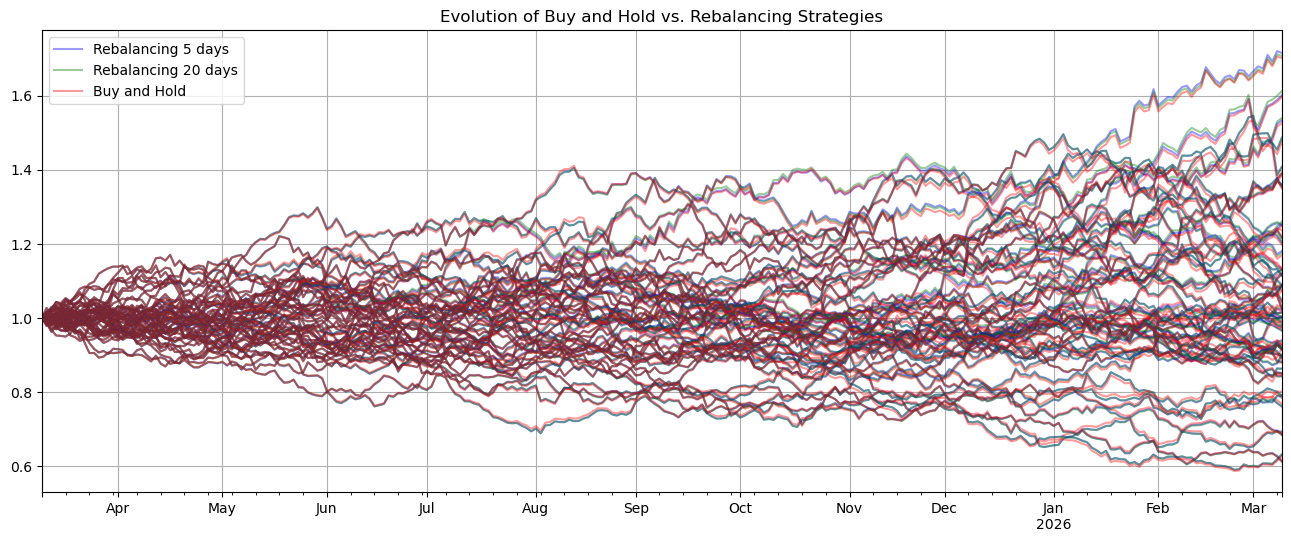

In [5]:
plt.figure(figsize=(16, 6))

lines = []
evolution_rebal_5 = simulation_rebal_5.evolutions
evolution_buy_hold = simulation_buy_hold.evolutions
evolution_rebal_20 = simulation_rebal_20.evolutions

for evolution_name, evolution_data in evolution_rebal_5.items():
    lines.append(evolution_data.sum(axis=1).plot(color="blue", alpha=0.4, label="Rebalancing 5 days"))
    lines.append(evolution_rebal_20[evolution_name].sum(axis=1).plot(color="green", alpha=0.4, label="Rebalancing 20 days"))
    lines.append(evolution_buy_hold[evolution_name].sum(axis=1).plot(color="red", alpha=0.4, label="Buy and Hold"))

plt.title("Evolution of Buy and Hold vs. Rebalancing Strategies")
plt.grid()

# Get unique legend handles and labels
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.show()

## Create Simulations with ESG Constraints

Create portfolio simulations with ESG constraints.

In [6]:
# Number of scenarios
nb_scenarios = 500

# Create simulation with strict ESG constraints
parameters_strict_esg = {
    "Begin date": '2025-03-10',
    "End date": '2026-03-10'
}

simulation_strict_esg = Simulation(nb_scenarios=nb_scenarios, model=market_model_BS, strategy="Buy and hold", parameters=parameters_strict_esg)
simulation_strict_esg.set_dataESG(data_esg)

constraints_strict = {
    "List" : ["Maximal allocation", "Maximal volatility", "Maximal Carbon risk", "Maximal Carbon intensity (Tons of CO2)", "Minimal Score management"],
    "Value" : [0.2, 0.20, 3.5, 40, 65]
}

simulation_strict_esg.set_constraints(constraints_strict)
simulation_strict_esg.compute_allocation()
simulation_strict_esg.generate_scenarios()
simulation_strict_esg.generate_evolutions()

# Create simulation with relaxed ESG constraints
parameters_relaxed_esg = {
    "Begin date": '2025-03-10',
    "End date": '2026-03-10',
    "Rebalancing period": 20
}

simulation_relaxed_esg = deepcopy(simulation_strict_esg)
simulation_relaxed_esg.set_parameters(parameters_relaxed_esg)

constraints_relaxed = {
    "List" : ["Maximal allocation", "Maximal volatility", "Maximal Carbon risk", "Maximal Carbon intensity (Tons of CO2)", "Minimal Score management"],
    "Value" : [0.2, 0.25, 7, 2000, 50]
}

simulation_relaxed_esg.set_constraints(constraints_relaxed)
simulation_relaxed_esg.compute_allocation()
simulation_relaxed_esg.generate_evolutions()

/Users/dereckewane/Desktop/Cutting-edge-main 5/notebooks/../src/simulations/simulation.py:100: UserWarning: Strategy changed to 'Rebalancing'. Positive rebalancing period is not needed for Buy and hold strategy.
To avoid this warning, please use set_strategy() method to change the strategy before updating parameters.
  warnings.warn("Strategy changed to 'Rebalancing'. Positive rebalancing period is not needed for Buy and hold strategy.\n"


{'Evolution 1':             PERNODRICARD          LVMH        THALES  TELEPERFORMANCE  \
 2025-03-10  1.562088e-11  5.807097e-11  4.925782e-11     1.767444e-11   
 2025-03-11  1.559826e-11  5.733809e-11  4.790378e-11     1.732398e-11   
 2025-03-12  1.562189e-11  5.680588e-11  4.783048e-11     1.720626e-11   
 2025-03-13  1.577921e-11  5.821658e-11  4.866881e-11     1.732156e-11   
 2025-03-14  1.578168e-11  5.904876e-11  4.827713e-11     1.723619e-11   
 ...                  ...           ...           ...              ...   
 2026-03-04  1.508041e-11  5.819893e-11  5.155520e-11     1.569556e-11   
 2026-03-05  1.482741e-11  5.784727e-11  5.182317e-11     1.497916e-11   
 2026-03-06  1.470351e-11  5.664325e-11  5.134267e-11     1.504753e-11   
 2026-03-09  1.477951e-11  5.443310e-11  4.556883e-11     1.648169e-11   
 2026-03-10  1.461702e-11  5.391173e-11  4.529026e-11     1.659557e-11   
 
                   ORANGE      BOUYGUES         ENGIE       RENAULT  \
 2025-03-10  2.014236e-1

## Compare Portfolio Metrics

Calculate and compare portfolio metrics for the different ESG-constrained portfolios.

In [7]:
# Get model parameters
returns = market_model_BS.parameters["Returns"]
volatilities = market_model_BS.parameters["Volatilities"]
correlation_matrix = market_model_BS.parameters["Correlation matrix"]
cov_matrix = np.diag(volatilities) @ correlation_matrix @ np.diag(volatilities)

# Calculate metrics for strict ESG portfolio
allocation_strict = simulation_strict_esg.parameters["Allocation"]
portfolio_return_strict = allocation_strict @ returns
portfolio_variance_strict = allocation_strict @ cov_matrix @ allocation_strict
portfolio_carbon_risk_strict = allocation_strict @ data_esg["Carbon risk"]
portfolio_carbon_intensity_strict = allocation_strict @ data_esg["Carbon intensity (Tons of CO2)"]
portfolio_score_management_strict = allocation_strict @ data_esg["Score management"]

print("Portfolio with Strict ESG Constraints:")
print(f"Portfolio return: {portfolio_return_strict:.4f}")
print(f"Portfolio volatility: {np.sqrt(portfolio_variance_strict):.4f}")
print(f"Portfolio Carbon risk: {portfolio_carbon_risk_strict:.4f}")
print(f"Portfolio Carbon intensity: {portfolio_carbon_intensity_strict:.4f}")
print(f"Portfolio Score management: {portfolio_score_management_strict:.4f}")

# Calculate metrics for relaxed ESG portfolio
allocation_relaxed = simulation_relaxed_esg.parameters["Allocation"]
portfolio_return_relaxed = allocation_relaxed @ returns
portfolio_variance_relaxed = allocation_relaxed @ cov_matrix @ allocation_relaxed
portfolio_carbon_risk_relaxed = allocation_relaxed @ data_esg["Carbon risk"]
portfolio_carbon_intensity_relaxed = allocation_relaxed @ data_esg["Carbon intensity (Tons of CO2)"]
portfolio_score_management_relaxed = allocation_relaxed @ data_esg["Score management"]

print("\nPortfolio with Relaxed ESG Constraints:")
print(f"Portfolio return: {portfolio_return_relaxed:.4f}")
print(f"Portfolio volatility: {np.sqrt(portfolio_variance_relaxed):.4f}")
print(f"Portfolio Carbon risk: {portfolio_carbon_risk_relaxed:.4f}")
print(f"Portfolio Carbon intensity: {portfolio_carbon_intensity_relaxed:.4f}")
print(f"Portfolio Score management: {portfolio_score_management_relaxed:.4f}")

Portfolio with Strict ESG Constraints:
Portfolio return: 0.1228
Portfolio volatility: 0.2000
Portfolio Carbon risk: 3.5000
Portfolio Carbon intensity: 12.9737
Portfolio Score management: 65.0000

Portfolio with Relaxed ESG Constraints:
Portfolio return: 0.1433
Portfolio volatility: 0.2231
Portfolio Carbon risk: 7.0000
Portfolio Carbon intensity: 12.8212
Portfolio Score management: 65.1673


## Calculate Risk Metrics

Calculate risk metrics for the ESG-constrained portfolios.

In [8]:
# Calculate risk metrics for strict ESG portfolio
simulation_strict_esg.compute_metrics()
print("Risk Metrics for Strict ESG Portfolio:")
print(simulation_strict_esg.metrics)

# Calculate risk metrics for relaxed ESG portfolio
simulation_relaxed_esg.compute_metrics()
print("\nRisk Metrics for Relaxed ESG Portfolio:")
print(simulation_relaxed_esg.metrics)

Risk Metrics for Strict ESG Portfolio:
{'Mean terminal value': 1.0413, 'Median terminal value': 1.0176, 'Volatility of terminal value': 0.2117, 'VaR(95.0%)': 0.7306, 'ES(95.0%)': 0.6827}

Risk Metrics for Relaxed ESG Portfolio:
{'Mean terminal value': 1.0445, 'Median terminal value': 1.02, 'Volatility of terminal value': 0.2314, 'VaR(95.0%)': 0.7164, 'ES(95.0%)': 0.6479}


## Visualize Portfolio Evolutions

Plot the evolution of portfolio values for the ESG-constrained portfolios.

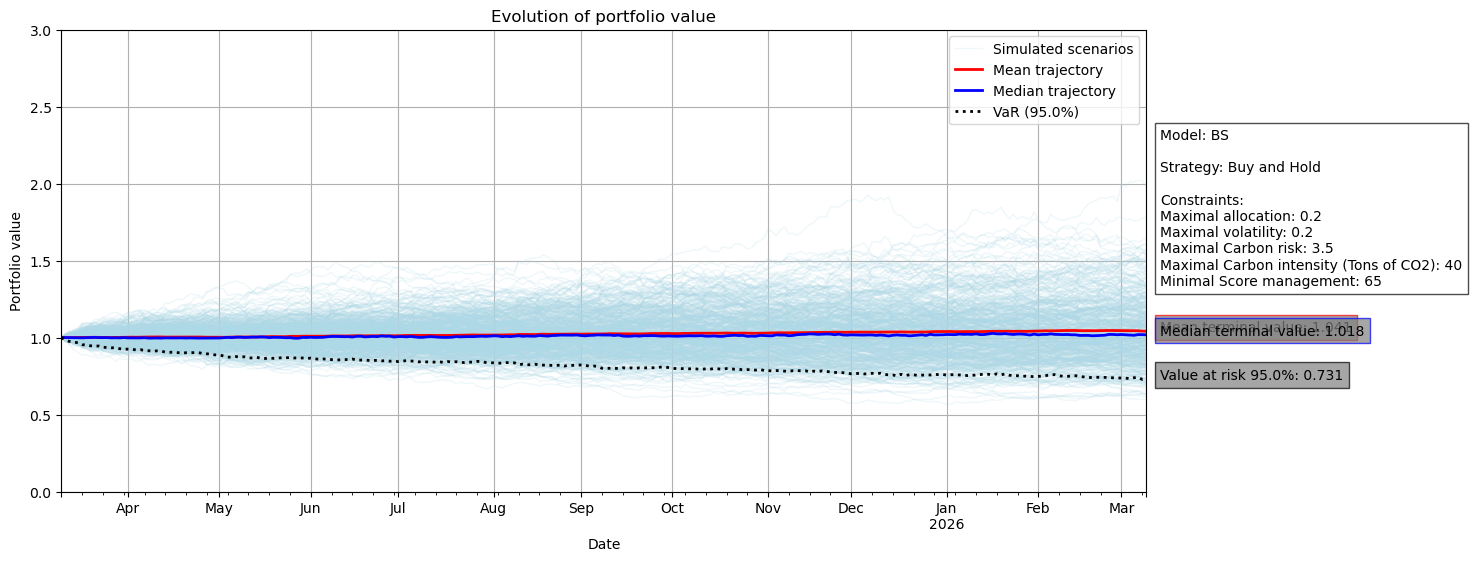

In [9]:
# Plot strict ESG portfolio evolution
simulation_strict_esg.plot()

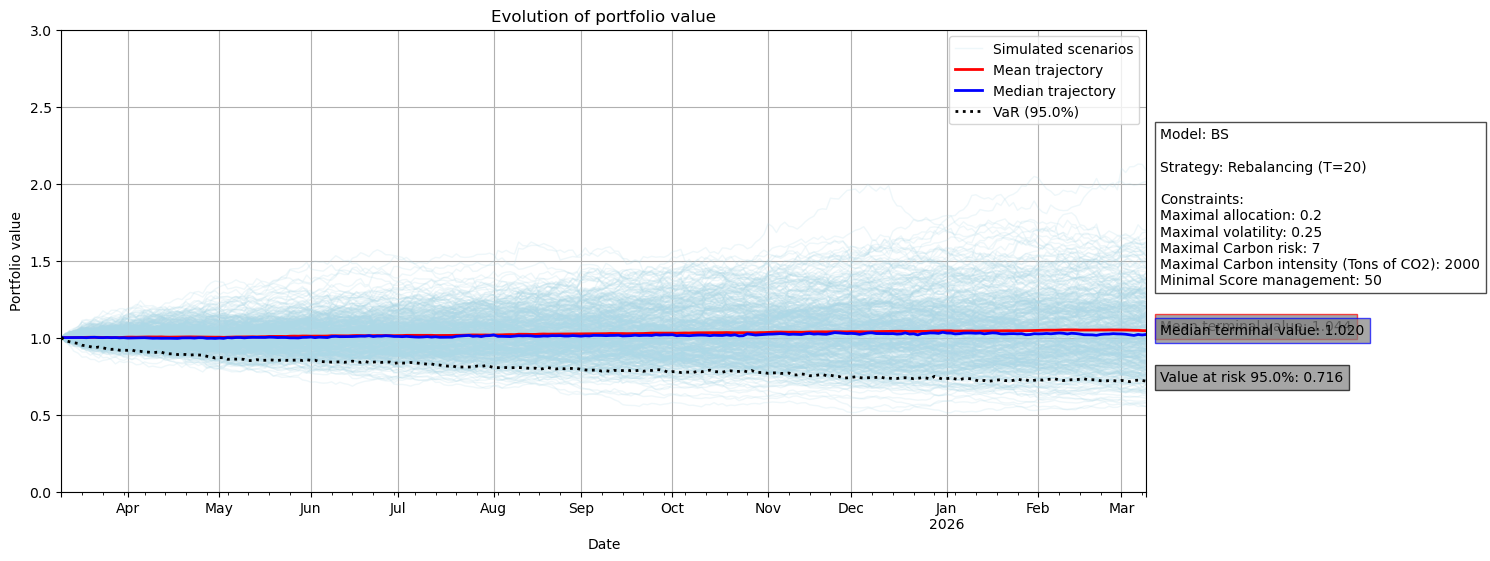

In [10]:
# Plot relaxed ESG portfolio evolution
simulation_relaxed_esg.plot()